# 1. Operazioni preliminari


## 1.1 Creazione del test set

In [ ]:
import os
import csv
import shutil
import random

# Parametri
csv_file = '.\\dataset\\test_set.csv' # Percorso al file CSV contenente gli ID delle persone da inserire nel dataset finale (es. 'n000016'). Ogni riga deve contenere almeno un ID
dataset_directory_origin = '.\\dataset\\vggface2_train\\train' # Directory di origine contenente le sottocartelle per ogni ID persona con le immagini
dataset_directory_destination = '.\\dataset\\test_set' # Directory in cui salvare le immagini selezionate
number_img = 10 # Numero massimo di immagini da copiare per ciascun ID

# Lettura del file CSV contenente gli ID delle persone
with open(csv_file, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')  # i campi sono separati da virgole

    for row in reader:
        if len(row) < 1:
            continue  # salta righe vuote

        person_id = row[0].strip()  # es: "n000016"
        person_name = row[1].strip(' "')

        # Costruzione dei percorsi di origine e destinazione per ogni persona
        origin_path = os.path.join(dataset_directory_origin, person_id)
        destination_path = os.path.join(dataset_directory_destination, person_id)

        if not os.path.exists(origin_path):
            print(f"Cartella non trovata: {origin_path}")
            continue

        # Lista dei file immagine nella cartella della persona
        images = [f for f in os.listdir(origin_path) if os.path.isfile(os.path.join(origin_path, f))]
        if not images:
            print(f"Nessuna immagine in: {origin_path}")
            continue

        # Seleziona un numero massimo di immagini in modo casuale
        random.seed(2025)
        selected_images = random.sample(images, min(number_img, len(images)))

        # Crea la cartella di destinazione se non esiste
        os.makedirs(destination_path, exist_ok=True)

        # Copia e rinomina le immagini nella cartella di destinazione
        for idx, image in enumerate(selected_images):
            src = os.path.join(origin_path, image)
            ext = os.path.splitext(image)[1]  # estensione del file (es. .jpg)
            dst_filename = f"{person_id}_{idx + 1:02d}{ext}"  # es: n000016_01.jpg
            dst = os.path.join(destination_path, dst_filename)
            shutil.copy2(src, dst)

        print(f"Copiate {len(selected_images)} immagini per {person_name}")

## 1.2 Definizione di costanti e funzioni di utilità

In [1]:
import torch
from torchvision import transforms
import os
import csv
import numpy as np
from PIL import Image
from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.optim import Adam
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool, CarliniLInfMethod

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

NN1 = InceptionResnetV1(pretrained='vggface2').eval()
NN1.to(device)
NN1.classify = True
print("Modello NN1 caricato correttamente")
num_classes = 8631

# Classe per la gestione del dataset
class FaceDataset(Dataset):
    def __init__(self, images_dir, csv_path, label_map_path):
        self.images_dir = images_dir
        self.transform = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor()
        ])
        self.samples = []

        # Carica le etichette vere (str -> int)
        LABELS = np.load(label_map_path)
        self.true_labels = {str(name).strip(): idx for idx, name in enumerate(LABELS)}

        # Legge il CSV e costruisce i path delle immagini e le label
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            for row in reader:
                person_dir, name = row[0], row[1].strip(' "')
                full_dir = os.path.join(images_dir, person_dir)
                if os.path.isdir(full_dir):
                    for img_file in os.listdir(full_dir):
                        img_path = os.path.join(full_dir, img_file)
                        if os.path.isfile(img_path):
                            label = self.true_labels.get(name)
                            if label is not None:
                                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_true_label(self, name):
        return self.true_labels.get(name)

    def get_used_labels(self):
        return sorted({label for _, label in self.samples})

test_set = FaceDataset(
    images_dir="./dataset/test_set",
    csv_path="./dataset/test_set.csv",
    label_map_path="./dataset/rcmalli_vggface_labels_v2.npy"
)

dataloader = DataLoader(test_set, batch_size=32, shuffle=False)
test_images, test_labels = [], []

for images, labels in dataloader:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Definizione del classificatore
classifier = PyTorchClassifier(
    model=NN1,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=Adam(NN1.parameters(), lr=0.001),
    input_shape=(3, 160, 160),
    channels_first=True,
    nb_classes=num_classes,
    clip_values=(0.0, 1.0),
    device_type="gpu" if torch.cuda.is_available() else "cpu"
)

def compute_accuracy(classifier, x_test, y_test):
    # Predizioni del modello (output con le probabilità per ogni classe)
    y_pred = classifier.predict(x_test)  # Shape: (N, 10)

    # Convertiamo da probabilità a etichette (argmax sulle colonne)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Predizioni finali

    # Calcoliamo l'accuratezza
    accuracy = accuracy_score(y_pred_labels, y_test)
    return accuracy

Using device: cuda
Modello NN1 caricato correttamente


# 2. Calcolo delle performance sui dati clean

In [3]:
accuracy_clean = compute_accuracy(classifier, test_images, test_labels)
print(f"Accuracy del classificatore su dati clean: {accuracy_clean}")

Accuracy del classificatore su dati clean: 0.818


# 3. Attacks using the Adversarial Robustness Toolbox (ART)

## FGSM attack
See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm

### Non-targeted (error-generic) FGSM attack

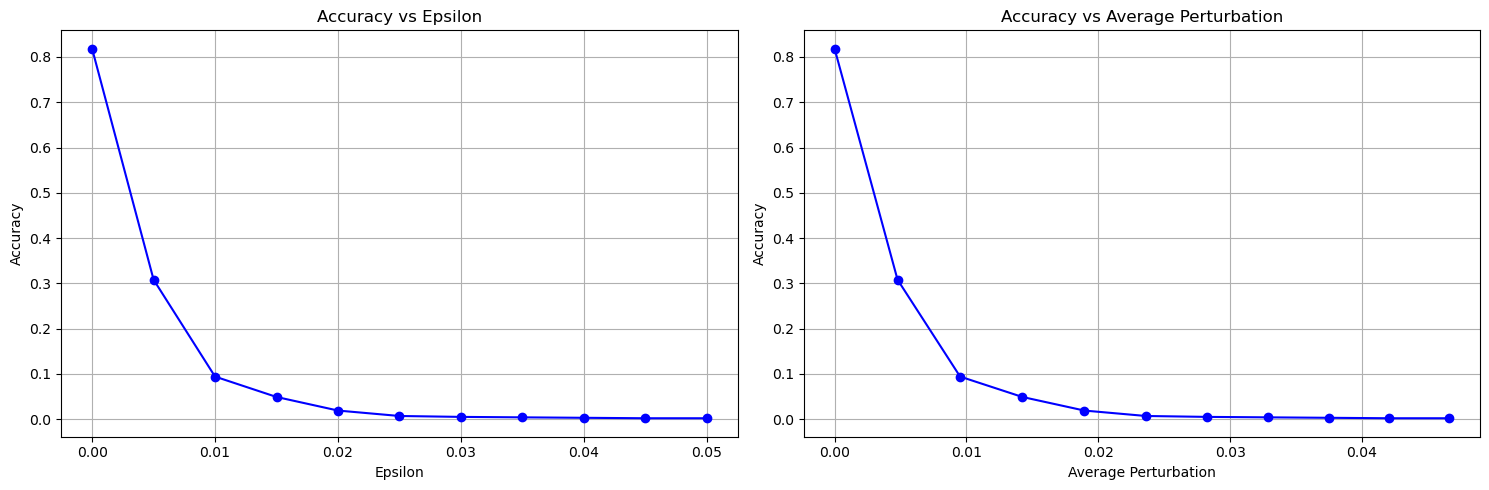

In [5]:
# Calcolo dell'accuracy al variare di epsilon e della perturbazione media

epsilon_values = np.linspace(0.00, 0.05, 11) # [0.00, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

accuracies = []
average_perturbations = []

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Epsilon")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs Epsilon")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy vs Average Perturbation")
axes[1].grid()

plt.tight_layout()
plt.show()

### Targeted (error-specific) FGSM Attack

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di epsilon e della perturbazione media (con la target_class fissato)

epsilon_values = [0.00, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(epsilon_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].legend(["Accuracy", "Targeted Accuracy"])
axes[0].set_xlabel("Epsilon")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Epsilon (target_class = {target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].legend(["Accuracy", "Targeted Accuracy"])
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation (target_class = {target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare della classe target (con epsilon fissato)

epsilon = 0.05
target_class_values = test_set.get_used_labels()

accuracies = []
average_perturbations = []
targeted_accuracies = []

for target_class in target_class_values:
    # Definizione dell'attacco
    attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Target Class
axes[0].plot(target_class_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Target Class")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Target Class (epsilon = {epsilon})")
axes[0].grid()

# Targeted Accuracy vs Target Class
axes[1].plot(target_class_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Target Class")
axes[1].set_ylabel("Targeted Accuracy")
axes[1].set_title(f"Targeted Accuracy vs Target Class (epsilon = {epsilon})")
axes[1].grid()

plt.tight_layout()
plt.show()

## BIM attack
See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#basic-iterative-method-bim

### Non-targeted (error-generic) BIM attack

In [ ]:
# Calcolo dell'accuracy al variare di epsilon e della perturbazione media (con epsilon_step e epsilon_step fissati)

epsilon_values = [0.01, 0.02, 0.03, 0.04, 0.05]
epsilon_step = 0.01
max_iter = 5

accuracies = []
average_perturbations = []

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Epsilon")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Epsilon (epsilon_step = {epsilon_step}, max_iter = {max_iter}))")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon_step = {epsilon_step}, max_iter = {max_iter}))")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare di epsilon_step e della perturbazione media (con epsilon e max_iter fissati)

epsilon = 0.025
epsilon_step_values = [0.005, 0.01, 0.015, 0.02, 0.025]
max_iter = 5

accuracies = []
average_perturbations = []

for epsilon_step in epsilon_step_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Epsilon Step
axes[0].plot(epsilon_step_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Epsilon Step")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Epsilon Step (epsilon = {epsilon}, max_iter = {max_iter})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon = {epsilon}, max_iter = {max_iter})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare di max_iter e della perturbazione media (con epsilon e epsilon_step fissati)

epsilon = 0.025
epsilon_step = 0.01
max_iter_values = [1, 2, 5, 10, 20]

accuracies = []
average_perturbations = []

for epsilon_step in epsilon_step_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Max Iterations
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Max Iterations")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Max Iterations (epsilon = {epsilon}, epsilon_step = {epsilon_step})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon = {epsilon}, epsilon_step = {epsilon_step})")
axes[1].grid()

plt.tight_layout()
plt.show()

### Targeted (error-specific) BIM attack

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di epsilon e della perturbazione media (con epsilon_step, max_iter e target_class fissati)

epsilon_values = [0.01, 0.02, 0.03, 0.04, 0.05]
epsilon_step = 0.01
max_iter = 5
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies =[]

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(epsilon_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].legend(["Accuracy", "Targeted Accuracy"])
axes[0].set_xlabel("Epsilon")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Epsilon \n (epsilon_step = {epsilon_step}, max_iter = {max_iter}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].legend(["Accuracy", "Targeted Accuracy"])
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (epsilon_step = {epsilon_step}, max_iter = {max_iter}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di epsilon_step e della perturbazione media (con epsilon, max_iter e target_class fissati)

epsilon = 0.025
epsilon_step_values = [0.005, 0.01, 0.015, 0.02, 0.025]
max_iter = 5
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for epsilon_step in epsilon_step_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Epsilon Step
axes[0].plot(epsilon_step_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(epsilon_step_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].legend(["Accuracy", "Targeted Accuracy"])
axes[0].set_xlabel("Epsilon Step")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Epsilon Step \n (epsilon = {epsilon}, max_iter = {max_iter}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].legend(["Accuracy", "Targeted Accuracy"])
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (epsilon = {epsilon}, max_iter = {max_iter}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di max_iter e della perturbazione media (con epsilon, epsilon_step e target_class fissati)

epsilon = 0.025
epsilon_step = 0.01
max_iter_values = [1, 2, 5, 10, 20]
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for max_iter in max_iter_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Max Iterations
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(max_iter_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].set_xlabel("Max Iterations")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Max Iterations \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, target_class={target_class})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare della classe target e della perturbazione media (con epsilon, epsilon_step e max_iter fissati)

epsilon = 0.025
epsilon_step = 0.01
max_iter = 5
target_class_values = test_set.get_used_labels()

accuracies = []
average_perturbations = []
targeted_accuracies = []

for target_class in target_class_values:
    # Definizione dell'attacco
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Target Class
axes[0].plot(target_class_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Target Class")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Target Class \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, max_iter={max_iter})")
axes[0].grid()

# Targeted Accuracy vs Target Class
axes[1].plot(target_class_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Target Class")
axes[1].set_ylabel("Targeted Accuracy")
axes[1].set_title(f"Targeted Accuracy vs Target Class \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, max_iter={max_iter})")
axes[1].grid()

plt.tight_layout()
plt.show()

## PGD attack
See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd

### Non-targeted (error-generic) PGD attack

In [ ]:
# Calcolo dell'accuracy al variare di epsilon e della perturbazione media (con epsilon_step e epsilon_step fissati)

epsilon_values = [0.01, 0.02, 0.03, 0.04, 0.05]
epsilon_step = 0.01
max_iter = 5

accuracies = []
average_perturbations = []

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Epsilon")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Epsilon (epsilon_step = {epsilon_step}, max_iter = {max_iter}))")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon_step = {epsilon_step}, max_iter = {max_iter}))")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare di epsilon_step e della perturbazione media (con epsilon e max_iter fissati)

epsilon = 0.025
epsilon_step_values = [0.005, 0.01, 0.015, 0.02, 0.025]
max_iter = 5

accuracies = []
average_perturbations = []

for epsilon_step in epsilon_step_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Epsilon Step
axes[0].plot(epsilon_step_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Epsilon Step")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Epsilon Step (epsilon = {epsilon}, max_iter = {max_iter})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon = {epsilon}, max_iter = {max_iter})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare di max_iter e della perturbazione media (con epsilon e epsilon_step fissati)

epsilon = 0.025
epsilon_step = 0.01
max_iter_values = [1, 2, 5, 10, 20]

accuracies = []
average_perturbations = []

for epsilon_step in epsilon_step_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Max Iterations
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Max Iterations")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Max Iterations (epsilon = {epsilon}, epsilon_step = {epsilon_step})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon = {epsilon}, epsilon_step = {epsilon_step})")
axes[1].grid()

plt.tight_layout()
plt.show()

### Targeted (error-specific) PGD attack

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di epsilon e della perturbazione media (con epsilon_step, max_iter e target_class fissati)

epsilon_values = [0.01, 0.02, 0.03, 0.04, 0.05]
epsilon_step = 0.01
max_iter = 5
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies =[]

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(epsilon_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].legend(["Accuracy", "Targeted Accuracy"])
axes[0].set_xlabel("Epsilon")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Epsilon \n (epsilon_step = {epsilon_step}, max_iter = {max_iter}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].legend(["Accuracy", "Targeted Accuracy"])
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (epsilon_step = {epsilon_step}, max_iter = {max_iter}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di epsilon_step e della perturbazione media (con epsilon, max_iter e target_class fissati)

epsilon = 0.025
epsilon_step_values = [0.005, 0.01, 0.015, 0.02, 0.025]
max_iter = 5
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for epsilon_step in epsilon_step_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Epsilon Step
axes[0].plot(epsilon_step_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(epsilon_step_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].legend(["Accuracy", "Targeted Accuracy"])
axes[0].set_xlabel("Epsilon Step")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Epsilon Step \n (epsilon = {epsilon}, max_iter = {max_iter}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].legend(["Accuracy", "Targeted Accuracy"])
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (epsilon = {epsilon}, max_iter = {max_iter}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di max_iter e della perturbazione media (con epsilon, epsilon_step e target_class fissati)

epsilon = 0.025
epsilon_step = 0.01
max_iter_values = [1, 2, 5, 10, 20]
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for max_iter in max_iter_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Max Iterations
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(max_iter_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].set_xlabel("Max Iterations")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Max Iterations \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare della classe target e della perturbazione media (con epsilon, epsilon_step e max_iter fissati)

epsilon = 0.025
epsilon_step = 0.01
max_iter = 5
target_class_values = test_set.get_used_labels()

accuracies = []
average_perturbations = []
targeted_accuracies = []

for target_class in target_class_values:
    # Definizione dell'attacco
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, random_eps=True, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv, test_labels)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv - test_images))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Target Class
axes[0].plot(target_class_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Target Class")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Target Class \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, max_iter={max_iter})")
axes[0].grid()

# Targeted Accuracy vs Target Class
axes[1].plot(target_class_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Target Class")
axes[1].set_ylabel("Targeted Accuracy")
axes[1].set_title(f"Targeted Accuracy vs Target Class \n (epsilon = {epsilon}, epsilon_step = {epsilon_step}, max_iter={max_iter})")
axes[1].grid()

plt.tight_layout()
plt.show()

## Deepfool attack
See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#deepfool

Nota: nella libreria ART non è implementata la versione targeted di DeepFool.

### Non-targeted (error-generic) DeepFool attack

In [ ]:
# Calcolo dell'accuracy al variare di epsilon e della perturbazione media (con max_iter fissato)

epsilon_values = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05]
max_iter = 5

accuracies = []
average_perturbations = []

for epsilon in epsilon_values:
    # Definizione dell'attacco
    attack = DeepFool(classifier=classifier, norm = linf,epsilon=epsilon, max_iter=max_iter)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Epsilon
axes[0].plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Epsilon")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Epsilon (max_iter = {max_iter})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (max_iter = {max_iter})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare del numero di iterazioni e della perturbazione media (con epsilon fissato)

epsilon = 0.05
max_iter_values = [1, 2, 5, 10, 20]

accuracies = []
average_perturbations = []

for max_iter in max_iter_values:
    # Definizione dell'attacco
    attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Max Iterations
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Max Iterations")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Max Iterations (epsilon = {epsilon})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation (epsilon = {epsilon})")
axes[1].grid()

plt.tight_layout()
plt.show()

## Carlini-Wagner attack

See the documentation here:
* https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#carlini-and-wagner-l-inf-attack

### Non-targeted (error-generic) Carlini-Wagner attack

In [ ]:
# Calcolo dell'accuracy al variare della confidence e della perturbazione media (con max_iter e learning_rate fissati)

confidence_values = [0.1, 0.5, 1, 2, 5, 10]
max_iter = 5
learning_rate = 0.01

accuracies = []
average_perturbations = []

for confidence in confidence_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Confidence
axes[0].plot(confidence_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Confidence")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Confidence \n (max_iter = {max_iter}, learning_rate = {learning_rate})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation \n (max_iter = {max_iter}, learning_rate = {learning_rate})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare di max_iter e della perturbazione media (con confidence e learning_rate fissati)

confidence = 0.5
max_iter_values = [1, 2, 5, 7, 10]
learning_rate = 0.01

accuracies = []
average_perturbations = []

for max_iter in max_iter_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Max Iter
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Max Iter")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Max Iter \n (confidence = {confidence}, learning_rate = {learning_rate})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation \n (confidence = {confidence}, learning_rate = {learning_rate})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy al variare del learning_rate e della perturbazione media (con confidence e max_iter fissati)

confidence = 0.5
max_iter = 5
learning_rate_values = [0.001, 0.005, 0.01, 0.05, 0.1]

accuracies = []
average_perturbations = []

for learning_rate in learning_rate_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=False)

    # Generazione delle immagini avversarie
    test_images_adv = attack.generate(test_images)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Learning Rate
axes[0].plot(learning_rate_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Learning Rate \n (confidence = {confidence}, max_iter = {max_iter})")
axes[0].grid()

# Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy")
axes[1].set_title(f"Accuracy vs Average Perturbation \n (confidence = {confidence}, max_iter = {max_iter})")
axes[1].grid()

plt.tight_layout()
plt.show()

### Targeted (error-specific) Carlini-Wagner attack

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di confidence e della perturbazione media (con max_iter, learning_rate, e target_class fissati)

confidence_values =  [0.1, 0.5, 1, 2, 5, 10]
max_iter = 5
learning_rate = 0.01
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for confidence in confidence_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv_filtered, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Confidence
axes[0].plot(confidence_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(confidence_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].set_xlabel("Confidence")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Confidence \n (max_iter = {max_iter}, learning_rate = {learning_rate}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (max_iter = {max_iter}, learning_rate = {learning_rate}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di max_iter e della perturbazione media (con confidence, learning_rate e target_class fissati)

confidence = 0.5
max_iter_values = [1, 2, 5, 7, 10]
learning_rate = 0.01
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for max_iter in max_iter_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv_filtered, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Max Iter
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(max_iter_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].set_xlabel("Max Iter")
axes[0].set_ylabel("Accuracy and Targeted Accuracy")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Max Iter \n (confidence = {confidence}, learning_rate = {learning_rate}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy and Targeted Accuracy")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (confidence = {confidence}, learning_rate = {learning_rate}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare di learning_rate e della perturbazione media (con confidence, max_iter e target_class fissati)

confidence = 0.5
max_iter = 5
learning_rate_values = [0.001, 0.005, 0.01, 0.05, 0.1]
target_class = test_set.get_true_label("Cristiano_Ronaldo")

accuracies = []
average_perturbations = []
targeted_accuracies = []

for learning_rate in learning_rate_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv_filtered, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy and Targeted Accuracy vs Learning Rate
axes[0].plot(max_iter_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].plot(max_iter_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Accuracy and Targeted Accuracy")
axes[0].set_title(f"Accuracy and Targeted Accuracy vs Learning Rate \n (confidence = {confidence}, max_iter = {max_iter}, target_class={target_class})")
axes[0].grid()

# Accuracy and Targeted Accuracy vs Average Perturbation
axes[1].plot(average_perturbations, accuracies, marker='o', linestyle='-', color='b')
axes[1].plot(average_perturbations, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Average Perturbation")
axes[1].set_ylabel("Accuracy and Targeted Accuracy")
axes[1].set_title(f"Accuracy and Targeted Accuracy vs Average Perturbation \n (confidence = {confidence}, max_iter = {max_iter}, target_class={target_class})")
axes[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Calcolo dell'accuracy e della targeted accuracy al variare della classe target (con confidence, max_iter e learning_rate fissati)

confidence = 0.5
max_iter = 5
learning_rate = 0.01
target_class_values = test_set.get_used_labels()

accuracies = []
targeted_accuracies = []

for target_class in target_class_values:
    # Definizione dell'attacco
    attack = CarliniLInfMethod(classifier=classifier, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, targeted=True)

    # Generazione delle immagini avversarie
    targeted_labels = target_class*torch.ones(test_labels.size, dtype=torch.long)
    one_hot_targeted_labels = torch.nn.functional.one_hot(targeted_labels, num_classes = num_classes).numpy()
    test_images_adv = attack.generate(test_images, one_hot_targeted_labels)

    # Calcolo della massima perturbazione L_inf per ogni immagine
    perturbations = np.abs(test_images_adv - test_images)
    max_perturbation = np.max(perturbations.reshape(perturbations.shape[0], -1), axis=1)

    # Filtraggio delle immagini con L_inf ≤ 0.05
    test_images_adv_filtered = test_images_adv[max_perturbation <= 0.05]
    test_labels_filtered = test_labels[max_perturbation <= 0.05]

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label vere
    accuracy_test = compute_accuracy(classifier, test_images_adv_filtered, test_labels_filtered)
    accuracies.append(accuracy_test)

    # Calcolo della perturbazione media
    perturbation = np.mean(np.abs(test_images_adv_filtered - test_labels_filtered))
    average_perturbations.append(perturbation)

    # Calcolo dell'accuracy sulle immagini modificate rispetto alle label della classe target
    targeted_attack_accuracy = compute_accuracy(classifier, test_images_adv_filtered, targeted_labels)
    targeted_accuracies.append(targeted_attack_accuracy)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy vs Target Class
axes[0].plot(target_class_values, accuracies, marker='o', linestyle='-', color='b')
axes[0].set_xlabel("Target Class")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Accuracy vs Target Class \n (confidence={confidence}, max_iter={max_iter}, learning_rate={learning_rate})")
axes[0].grid()

# Targeted Accuracy vs Target Class
axes[1].plot(target_class_values, targeted_accuracies, marker='o', linestyle='-', color='r')
axes[1].set_xlabel("Target Class")
axes[1].set_ylabel("Targeted Accuracy")
axes[1].set_title(f"Targeted Accuracy vs Target Class \n (confidence={confidence}, max_iter={max_iter}, learning_rate={learning_rate})")
axes[1].grid()

plt.tight_layout()
plt.show()